**Semantic segmentation** is a pixel wise image classification technology, where each pixel in the image is labelled with different set of semantic labels.

Connecting to google drive for dataset directories

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import all the required dependencies

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import transforms as T

from PIL import Image
import albumentations as A

import time
from tqdm.notebook import tqdm

Load the dataset from drive<br>
The dataset consists of images and labelled masks in their respective folders.

In [ ]:
image_path = '/content/drive/MyDrive/dataset/images_prepped_train/'
mask_path = '/content/drive/MyDrive/dataset/annotations_prepped_train/'

Read the labelled classes and create an dataframe by joining the images and masked data

In [ ]:
classes = 23

def make_df():
    label = []
    for dirpath, _, files in os.walk(image_path):
        for filename in files:
            label.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': label}, index = np.arange(0, len(label)))

df = make_df()
print('Number of Images:', len(df))

Number of Images: 367


Reading and plotting the image and its annotated label for reference

In [ ]:
img = Image.open(image_path + df['id'][214] + '.png')
mask = Image.open(mask_path + df['id'][214] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)

Image Size (360, 480, 3)
Mask Size (360, 480)


Text(0.5, 1.0, 'image with annotations')

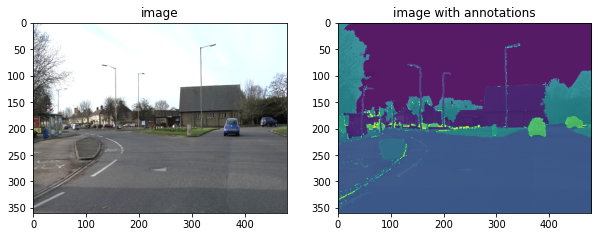

In [ ]:
fig = plt.figure(figsize=(10, 10))

rows = 1
columns = 2

fig.add_subplot(rows, columns, 1)
plt.imshow(img)
plt.title('image')

fig.add_subplot(rows, columns, 2)
plt.imshow(img)
plt.imshow(mask, alpha=0.9)
plt.title('image with annotations')


Importing the dataset split dependencies and the splitting the dataset into train, test and val datasets

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
trainval, test = train_test_split(df['id'].values, test_size=0.2, random_state=10)
train, valid = train_test_split(trainval, test_size=0.15, random_state=10)

print('Size of traindataset:',len(train))
print('Size of testdataset:',len(test))
print('Size of validdataset:',len(valid))

Size of traindataset: 249
Size of testdataset: 74
Size of validdataset: 44


Defining the required parameters

In [ ]:
DEVICE = 'cuda'
EPOCHS = 2
LR = 0.001
BATCH_SIZE = 3
weight_decay = 1e-4
WEIGHTS = 'imagenet'

**Encoder** : Is  a convolutional network used to extract features by downsampling images.

Details about selected Encoder are:


> **1. Vgg19**

Total Number of layers : 19 layers
(16 convolutional layers, 3 Fully Connected layer, 5 MaxPool layers and 1 SoftMax layer)

>**2. ResNet50**

(Set of 5 different convolutional layers with total of 50 layers(1+9+12+18+9+1), 1 MaxPool layer and average pool layer)

In [ ]:
ENCODER1 = 'resnet50'
ENCODER2 = 'vgg19' 

**Data Preprocessing**<br>Build customdataset using pytorch dataset class<br>Performed transform, resize and other image preprocessing methods using albumnetations.

In [ ]:
from torch.utils.data import Dataset, DataLoader
import albumentations as A

In [ ]:
class SemanticDataset(Dataset):
    
    def __init__(self, imgpath, maskpath, df, augs, mean, std, patch=False):
        self.imgpath = imgpath
        self.maskpath = maskpath
        self.df = df
        self.augs = augs
        #self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image = cv2.imread(self.imgpath + self.df[idx] + '.png')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.maskpath + self.df[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.augs:
            data = self.augs(image=image, mask=mask)
            img = Image.fromarray(data['image'])
            mask = data['mask']
        
        #if self.transform is None:
         #   img = Image.fromarray(img)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        image = t(img)
        mask = torch.from_numpy(mask).long()
        
        if self.patches:
            image, mask = self.tiles(image, mask)
            
        return image, mask

In [ ]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

def get_train_augs():
    return A.Compose([
        A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.GridDistortion(p=0.2),
        A.RandomBrightnessContrast((0,0.5),(0,0.5)),
        A.GaussNoise()
    ])

def get_valid_augs():
  return A.Compose([
      A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST),
      A.HorizontalFlip(),
      A.GridDistortion(p=0.2)
  ])
  

In [ ]:
#datasets
trainset = SemanticDataset(image_path, mask_path, train, get_train_augs(), mean, std, patch=False)
valset = SemanticDataset(image_path, mask_path, valid, get_valid_augs(), mean, std, patch=False)

print(f'size of trainset : {len(trainset)}')
print(f'size of validset : {len(valset)}') 

size of trainset : 249
size of validset : 44


Data is loaded into dataloaders using DataLoader class

In [ ]:
from torch.utils.data import DataLoader

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=True)

#Number of batches in each loaders
print(f'Total num of batches in trainloader : {len(trainloader)}')
print(f'Total num of batches in validloader : {len(valloader)}')
#To valid the tensor shape of each batch
for image, mask in trainloader:
    print(f'one batch image shape : {image.shape}')
    print(f'one batch image shape : {mask.shape}')
    break;

Total num of batches in trainloader : 83
Total num of batches in validloader : 15
one batch image shape : torch.Size([3, 3, 704, 1056])
one batch image shape : torch.Size([3, 704, 1056])


**Custom semantic segmentation models**<br>Initiate the pre-trained segmentation models from pytorch with its required parameters

In [ ]:
!pip install -q segmentation-models-pytorch
import segmentation_models_pytorch as smp

import torch.nn as nn

     |████████████████████████████████| 102 kB 7.8 MB/s 
     |████████████████████████████████| 376 kB 28.3 MB/s 
     |████████████████████████████████| 58 kB 7.4 MB/s 


**Decoder** : Is a convolutional network, used to upsample the data. It takes output from the encoder to predict segmented labels.
Below are the selected decoders.

> **1. UNet**

(23 convolutional layers with ReLu, 4 MaxPool layers and 4 Up-convolutional layers)
Consists of skip connections

> **2. FPN**
Feature pyramid network consists of bottom-up and top-down pathway and along with lateral connections to produce effective feature or spatial information extraction.

>  **3. PSPNet**
PSPNet consists of feature map network built using dilated convolutions and pyramid pooling module to produce global average pooling of the data.

> **4. DeepLabV3**
DeepLabV3 consists of convolutional layers, image pooling blocks and atrous spatial pyramid pooling to avoid spatial information loss



In [ ]:
class sematicmodel(nn.Module):
      def __init__(self):
        super(sematicmodel, self).__init__()

        self.backbone = smp.FPN(
            encoder_name = ENCODER1,
            encoder_weights = WEIGHTS,
            in_channels = 3,
            classes = 23,
            activation = None
        )

      def forward(self, image):
         logits = self.backbone(image)  
         #if mask != None:
            #return logits, DiceLoss(mode = 'binary')(logits, mask) + nn.BCEWithLogitsLoss()(logits, mask)
            
         return logits

In [ ]:
model = sematicmodel()
#model gets registered on the specified device
model.to(DEVICE)

In [ ]:
def semantic_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [ ]:
def mIoU(pred, mask, smooth=1e-10, classes=23):
    with torch.no_grad():
        pred = F.softmax(pred, dim=1)
        pred = torch.argmax(pred, dim=1)
        pred = pred.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, classes): #loop per pixel class
            true_class = pred == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

Defining trainloss and validloss functions

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, trainloader, valloader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(DEVICE)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(trainloader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(DEVICE); mask = mask_tiles.to(DEVICE);
            #forward
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += semantic_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(valloader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(DEVICE); mask = mask_tiles.to(DEVICE);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += semantic_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculation mean for each batch
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(valloader))


            if min_loss > (test_loss/len(valloader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(valloader))))
                min_loss = (test_loss/len(valloader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(valloader)))
                    

            if (test_loss/len(valloader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(valloader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            
            #iou
            val_iou.append(val_iou_score/len(valloader))
            train_iou.append(iou_score/len(trainloader))
            train_acc.append(accuracy/len(trainloader))
            val_acc.append(test_accuracy/ len(valloader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(trainloader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(valloader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(trainloader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(valloader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(trainloader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(valloader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [ ]:
#epoch = 5
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, LR, epochs=EPOCHS,
                                            steps_per_epoch=len(trainloader))

history = fit(EPOCHS, model, trainloader, valloader, criterion, optimizer, sched)

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 2.416 
Epoch:1/2.. Train Loss: 1.391.. Val Loss: 2.416.. Train mIoU:0.233.. Val mIoU: 0.149.. Train Acc:0.650.. Val Acc:0.503.. Time: 3.61m


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Loss Decreasing.. 2.416 >> 0.543 
Epoch:2/2.. Train Loss: 0.796.. Val Loss: 0.543.. Train mIoU:0.302.. Val mIoU: 0.355.. Train Acc:0.769.. Val Acc:0.827.. Time: 1.25m
Total time: 4.87 m


In [ ]:
torch.save(model,'bestmodel.pt')

In [ ]:
class semanticTestDataset(Dataset):
    
    def __init__(self, imgpath, maskpath, df, augs=None):
        self.imgpath = imgpath
        self.maskpath = maskpath
        self.df = df
        self.augs = augs
      
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.imgpath + self.df[idx] + '.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.maskpath + self.df[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.augs is not None:
            aug = self.augs(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.augs is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        
        return img, mask


ttest = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = semanticTestDataset(image_path, mask_path, test, augs=ttest)

In [ ]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(DEVICE); image=image.to(DEVICE)
    mask = mask.to(DEVICE)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [ ]:
image, mask = test_set[1]
pred, score = predict_image_mask_miou(model, image, mask)

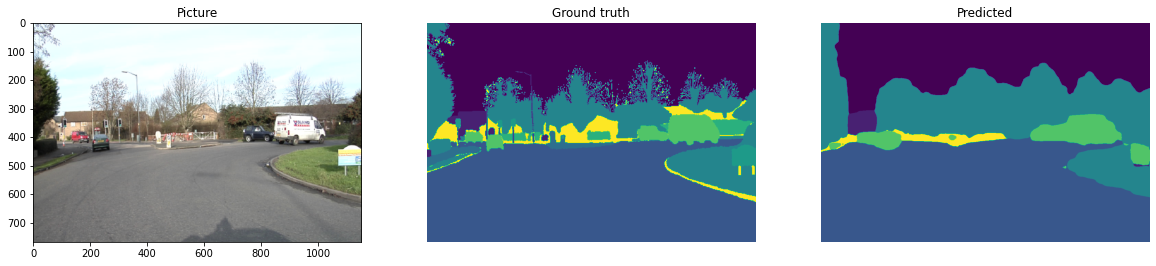

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred)
ax3.set_title('Predicted')
ax3.set_axis_off()

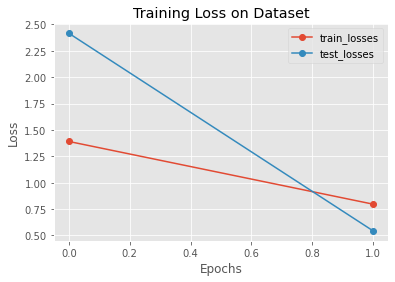

In [ ]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(history["train_loss"], label="train_losses", marker='o')
plt.plot(history["val_loss"], label="test_losses", marker='o')
plt.title("Training Loss on Dataset")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()

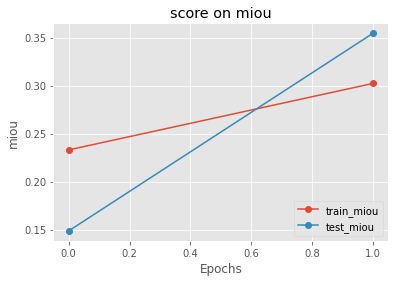

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(history["train_miou"], label="train_miou", marker='o')
plt.plot(history["val_miou"], label="test_miou", marker='o')
plt.title("score on miou")
plt.xlabel("Epochs")
plt.ylabel("miou")
plt.legend(loc="lower right")
plt.show()

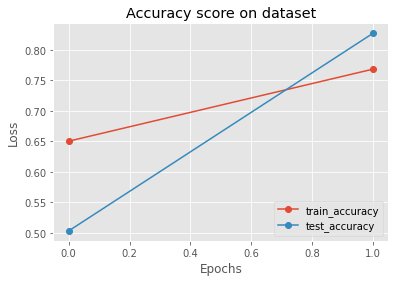

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(history["train_acc"], label="train_accuracy", marker='o')
plt.plot(history["val_acc"], label="test_accuracy",  marker='o')
plt.title("Accuracy score on dataset")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="lower right")
plt.show()